# Stats and Public Health Part 2

We have been provided with the data collected by the city of Chicago, Illinois who has been keeping track of mosquito populations and WNV prevalence using a series of traps that they place around the city. 

We will be analysing the data to see the relationship between the different variables and the mosquito number, as well as the probability of finding West Nile Virus (WNV) at any particular time and location.

## Table of Contents
[1. Loading data & checking high-level details](#Loading-data-&-checking-high-level-details) <br>
- [1.1Data Dictionary](#1.1Data-Dictionary)
- [1.2Visual check for our Numerical Data](#1.2Visual-check-for-our-Numerical-Data)
- [1.3Visual check for our Categorical Data](#1.3Visual-check-for-our-Categorical-Data)
- [1.4Changing categorical columns to fit them in our model](#1.4Changing-categorical-columns-to-fit-them-in-our-model)

[2. Linear regression model](#Linear-Regression) <br>
- [2.1Modelling using backward selection](#2.1Modelling-using-backward-selection)
- [2.2Modelling using forward selection](#2.2Modelling-using-forward-selection)
- [2.3Conclusion](#2.3Conclusion)


[3. Logistic regression model](#Logistic-Regression) <br>
- [3.1Modelling using backward selection](#3.1Modelling-using-backward-selection)
- [3.2Modelling using forward selection](#3.2Modelling-using-forward-selection)
- [3.3Conclusion](#3.3Conclusion)

In [1]:
#importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm

### Loading-data-&-checking-high-level-details

In [2]:
# loading the data
wnv=pd.read_csv('data/mosquito_data_part_2.csv') 

In [3]:
# View the dataframe head
wnv.head()

,Year,Week,Address Block,Trap,Trap type,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month
0,2019,39,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.977738,-87.880969,9
1,2019,39,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.798211,-87.736925,9
2,2019,39,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.987245,-87.689417,9
3,2019,39,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.953664,-87.724987,9
4,2019,39,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,9,negative,CULEX RESTUANS,41.657069,-87.546049,9


In [4]:
#view the tail
wnv.tail()

,Year,Week,Address Block,Trap,Trap type,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month
18490,2016,36,3XX W 18TH ST,T043,GRAVID,2016-09-09 00:09:00,4,positive,CULEX PIPIENS,41.857843,-87.635858,9
18491,2007,34,46XX N MILWAUKEE AVE,T003,GRAVID,2007-08-24 00:08:00,19,positive,CULEX PIPIENS,41.965376,-87.758403,8
18492,2016,30,127XX S DOTY AVE,T115,GRAVID,2016-07-27 00:07:00,34,positive,CULEX RESTUANS,41.662395,-87.590176,7
18493,2017,33,20XX N DOMINICK ST,T240B,SENTINEL,2017-08-17 00:08:00,50,positive,CULEX RESTUANS,41.919197,-87.664758,8
18494,2015,33,100XX W OHARE AIRPORT,T902,GRAVID,2015-08-20 00:08:00,6,positive,CULEX RESTUANS,41.977738,-87.880969,8


#### Dropping the unneeded column

We can see that week, month and year value can be easily calculated from the date column. It is good that we already have year and month values separated form the date but we don't see the need for Week column.

I will be dropping the date column as well as it is possible that date and time stamp tell us about the date when data was entered into the system for a particular month. It may not make much sense to keep the days and time in our model.

In [5]:
#dropping week and date column in place so that our wnv dataframe gets rid of these columns
wnv.drop(columns=['Week', 'Date'], inplace=True)

We now have another column trap names. It is just the name of the traps so it will not be much useful in predicting the mosquito numbers or the wnv virus. Even then before we drop, I want to check if there is any relation with the trap type or the address location.

In [6]:
#I want to understand if there is any relation between trap type and trap. 
wnv.loc[wnv['Trap type']== 'GRAVID'][ 'Trap']

0        T910
1        T114
2        T028
3        T228
4        T209
         ... 
18489    T155
18490    T043
18491    T003
18492    T115
18494    T902
Name: Trap, Length: 17741, dtype: object

In [7]:
#checking the trap names at few addresses.
wnv.loc[wnv['Address Block']== '3XX W 18TH ST'][ 'Trap']

2376     T043
3043     T043
3161     T043
3239     T043
3249     T043
         ... 
16884    T043
16965    T043
17229    T043
18227    T043
18490    T043
Name: Trap, Length: 80, dtype: object

In [8]:
#checking the trap names at few addresses.
wnv.loc[wnv['Address Block']== '127XX S DOTY AVE'][ 'Trap']

88       T115
158      T115
223      T115
411      T115
443      T115
         ... 
18311    T115
18401    T115
18418    T115
18434    T115
18492    T115
Name: Trap, Length: 299, dtype: object

We can say that Trap are just the names of the trap and the nomeclature is defined by trap location and it is independent of the trap type. We can ignore this column in our models.

In [9]:
#dropping the Trap column
wnv.drop(columns=['Trap'], inplace=True)

We also don't need the address block in our data model as we already have the Latitude and Longitude locations.

In [10]:
wnv.drop(columns=['Address Block'], inplace=True)

In [11]:
# Quickly checking the data types
wnv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             18495 non-null  int64  
 1   Trap type        18495 non-null  object 
 2   Mosquito number  18495 non-null  int64  
 3   WNV Present      18495 non-null  object 
 4   Species          18495 non-null  object 
 5   Lat              18495 non-null  float64
 6   Lon              18495 non-null  float64
 7   Month            18495 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1.1+ MB


In [12]:
# Take a look at the shape of dataset
print(f'There are {wnv.shape[0]} rows and {wnv.shape[1]} columns in the dataset.')

There are 18495 rows and 8 columns in the dataset.


In [13]:
# Checking for nulls
wnv.isnull().sum().any()

False

In [14]:
# Checking for duplicates
# Columns 
print(f'Duplicated columns: {wnv.T.duplicated().any()}')
# Rows 
print(f'Duplicated rows: {wnv.duplicated().any()}')

Duplicated columns: False
Duplicated rows: True


In [15]:
#What is the percentage of duplicate rows.
print(f"We have {round((wnv.duplicated().sum()/wnv.shape[0])*100)} % of duplicate rows in our data set")

We have 14 % of duplicate rows in our data set


This is a good percentage and we don't want to drop these many rows to reduce our sample size. It is possible that these duplicate rows are not true duplicates. We are not provided with any information about it. Maybe the same data was observed at these locations so we will be keeping them.

In [16]:
# Summary statistics 
wnv.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,18495.0,2012.905812,3.725857,2007.000000,2010.000000,2013.000000,2016.000000,2019.000000
Mosquito number,18495.0,10.879913,13.475066,1.000000,2.000000,5.000000,14.000000,50.000000
Lat,18495.0,41.852599,0.115419,41.644720,41.754148,41.872873,41.970102,42.017801
Lon,18495.0,-87.712611,0.095409,-87.880969,-87.778235,-87.703105,-87.643076,-87.531051
Month,18495.0,7.627088,0.998079,5.000000,7.000000,8.000000,8.000000,10.000000


### 1.1Data Dictionary

**Variables:**   

- `Year:` Year when the data was recorded (2007-2019).
- `Lat:` Latitude of the location where trap was installed (41.852599 - 42.017801).
- `Lon:` Longitude of the location where trap was installed (-87.712611 - -87.531051).
- `Month:` Month when data was recorede (May to October).
- `Mosquito Number:` Number of mosquito trapped in the installed traps (range(1-50)).
- `Trap type:` The type of trap (categorical).
- `Species:` Species of mosquito (categorical). 

**Target:**  
- `WNV Present`: Do we have WNV positive or negative? (categorical).

`Note`: Our target variable will be Mosquito number when we will be running a model to predict mosquito numbers. We will not be considering WNV present as a variable in that case as logically it is by-product not the cause of mosquito density. 

### 1.2Visual-check-for-our-Numerical-Data

Before we proceed with any analysis we will try to see the distribution of our data just to visually check the different columns we are provided with.

In [17]:
df_numerical_features = wnv.select_dtypes(include='number')
print('Numerical features', df_numerical_features.columns)
df_categorical_features = wnv.select_dtypes('object')
print('Categorical features', df_categorical_features.columns)

Numerical features Index(['Year', 'Mosquito number', 'Lat', 'Lon', 'Month'], dtype='object')
Categorical features Index(['Trap type', 'WNV Present', 'Species'], dtype='object')


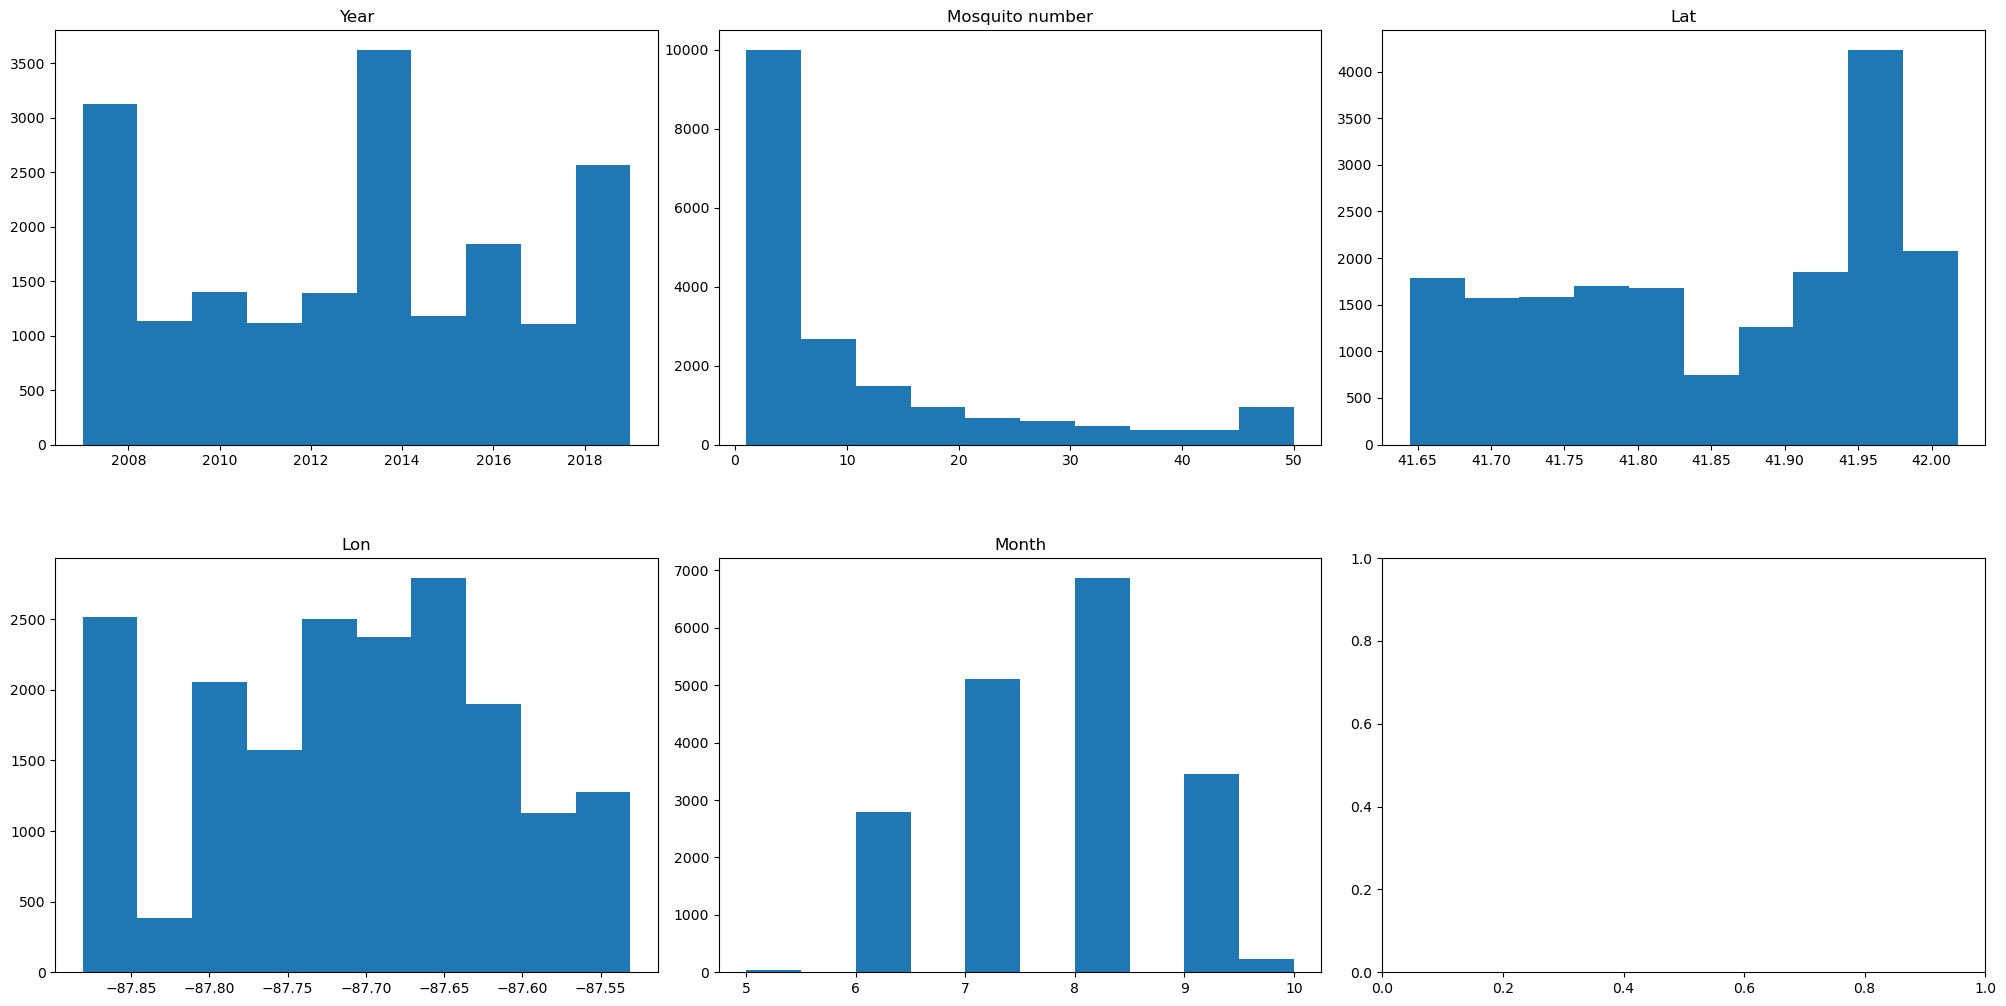

In [18]:
# Lets check out the distributions.

# Setting the plots layout
plt.subplots(2, 3, figsize=(20, 10))

# Plotting
for i, column in enumerate(df_numerical_features.columns, 1):
    plt.subplot(2, 3, i)
    plt.hist(wnv[column])
    plt.title(column)
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

#### Observations:

- We can see that distritution of all the numeric columns. 
    - The mosquito distribution is right skewed and there is a small peak at for count 50.
    - Year has a peak at the center but there are peaks at edges.
    - Logitude and month distribution are slightly normal.

**We are checking what is the average number of mosquitoes for each month and if it follows any trends.**

In [20]:
#Let us check What is the average number of mosquitoes for each month

wnv.groupby('Month')['Mosquito number'].mean().sort_values(ascending=False)

Month
8     12.111321
7     11.551879
6     10.264442
9      8.394973
10     5.377778
5      2.761905
Name: Mosquito number, dtype: float64

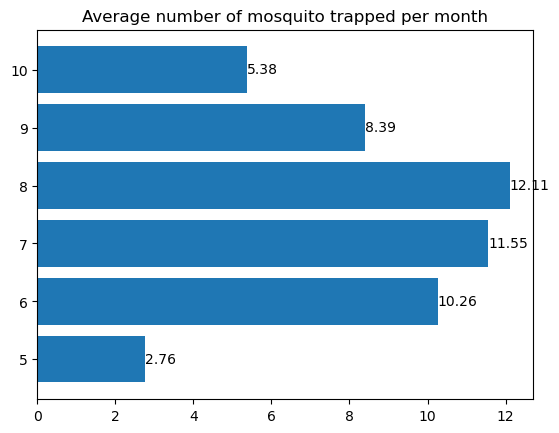

In [21]:
#plot to see the mosquito destribution by month.
a = wnv.groupby('Month')['Mosquito number'].mean().sort_values(ascending=False).index
b = wnv.groupby('Month')['Mosquito number'].mean().sort_values(ascending=False).values
fig, ax = plt.subplots()
hbars= ax.barh(a, b)
ax.bar_label(hbars, fmt='%.2f') 
ax.set_title('Average number of mosquito trapped per month')
plt.show()

Average number of mosquito trapped was maximum for the August month. In general, for the summer months the average is quite high. There is no data for mosquito trapped in winters and spring months (from November to April) probably because the harsh weather is reducing the mosquito population to negligible.

### 1.3Visual-check-for-our-Categorical-Data

We will plot the categorical columns to visually check our data

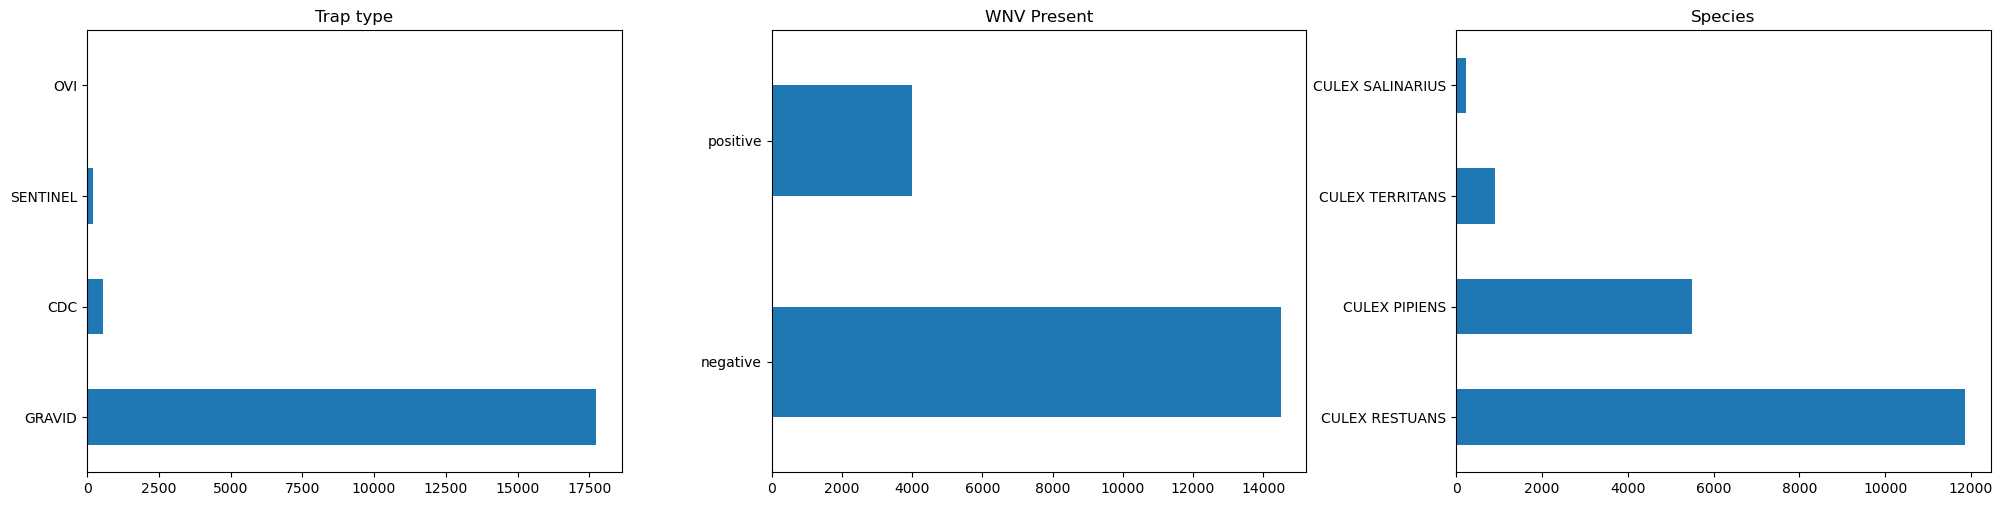

In [21]:
# Lets check out the distributions for categorical column.

# Setting the plots layout
plt.subplots(1, 3, figsize=(20, 5))

# Plotting
for i, column in enumerate(df_categorical_features.columns, 1):
    plt.subplot(1, 3, i)
    wnv[column].value_counts().plot(kind='barh')
    plt.title(column)
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

#### Observations:

- For the distribution of categorical data we have plotted bar graph.
    - The trap type Gravid is the most common one while we have very less almost negligible records were OVI was used.
    - The species Culex Restuans is the most common species and while the density of Culex Salinarius species is very less.
    - We have two outcomes either positive and negative for WNV prevalence.

We will be binarizing the WNV Present column so that we can use it in our model.

We need to convert out categorical data into numerical and for that reason we will be dummifying the Trap type and Species columns. 

### 1.4Changing-categorical-columns-to-fit-them-in-our-model

Let us firsh convert our WNV Present column to binary.

In [22]:
#quickly checking the wnv column
print(f"There are overall {(wnv['WNV Present'].value_counts(normalize= True)[0])*100} % negative and {(wnv['WNV Present'].value_counts(normalize= True)[1])*100} % positive WNV cases in our dataset")

There are overall 78.40497431738308 % negative and 21.59502568261692 % positive WNV cases in our dataset


In [23]:
#Convert the WNV Present column into a binary column (the text encoding to binary numeric {0,1})
wnv['WNV Present'] = np.where(wnv['WNV Present'] == 'positive',1,0)

In [24]:
#checking if it got converted or not.
wnv['WNV Present'].value_counts(normalize= True)

0    0.78405
1    0.21595
Name: WNV Present, dtype: float64

Let us proceed with dummifying the other categorical columns Species and Trap type. Before we proceed, we can check if there is a a statistically significant difference between the different mosquito species when looking at the occurrence of West Nile Virus.

We can check this by doing a chi square test of independence between the target variable WNV positive and species.
$$H_0 : if WNV is independent of Species or not.$$

In [25]:
#Is there a statistically significant difference between the different mosquito species 
#when looking at the occurrence of West Nile Virus?
ct1 = pd.crosstab(wnv['WNV Present'],wnv['Species'])
ct1

Species,CULEX PIPIENS,CULEX RESTUANS,CULEX SALINARIUS,CULEX TERRITANS
WNV Present,,,,
0,4074,9309,215,903
1,1412,2557,11,14


In [26]:
print(f"p-value for chi2 test: WNV positive vs Species {round(stats.chi2_contingency(ct1)[1],5)}")

p-value for chi2 test: WNV positive vs Species 0.0


The p-value for chi square test between WNV and species is 0.00 i.e it is very less. We can reject the null hypothesis that the WNV is independent of mosquito species. The mosquito species is influential in transmitting WNV virus.

Logically it doesn't make much sence to think that WNV is dependent on the trap type. Although trap type is responsible for catching the mosquito which is the cause of WNV virus. So we may try a Chi square test between WNV and Trap type.

In [27]:
#chi**2 test betwwen wnv and trap type.
ct2 = pd.crosstab(wnv['WNV Present'],wnv['Trap type'])
ct2

Trap type,CDC,GRAVID,OVI,SENTINEL
WNV Present,,,,
0,423,13951,1,126
1,121,3790,0,83


In [28]:
print(f"p-value for chi2 test: WNV positive vs Trap type {round(stats.chi2_contingency(ct2)[1],5)}")

p-value for chi2 test: WNV positive vs Trap type 0.0


Looking at the p-value for chi square test between WNV and trap type, we can reject the null hypothesis that the WNV is independent of trap type. We can proceed with using this variable in our model..

Let's now turn our attention to consolidating some of the levels in our categorical data to simplify our model before dummifying it.

In [29]:
wnv['Trap type'].value_counts()

GRAVID      17741
CDC           544
SENTINEL      209
OVI             1
Name: Trap type, dtype: int64

We observed the OVI only has one record so we can map it to next minimum category that is Sentinel.

In [32]:
wnv['Trap type'] = wnv['Trap type'].map({'OVI':'SENTINEL',
                                        'SENTINEL':'SENTINEL',
                                        'CDC':'CDC',
                                        'GRAVID':'GRAVID'})

In [33]:
wnv['Trap type'].value_counts()

GRAVID      17741
CDC           544
SENTINEL      210
Name: Trap type, dtype: int64

In [34]:
wnv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             18495 non-null  int64  
 1   Trap type        18495 non-null  object 
 2   Mosquito number  18495 non-null  int64  
 3   WNV Present      18495 non-null  int32  
 4   Species          18495 non-null  object 
 5   Lat              18495 non-null  float64
 6   Lon              18495 non-null  float64
 7   Month            18495 non-null  int64  
dtypes: float64(2), int32(1), int64(3), object(2)
memory usage: 1.1+ MB


Dummifying the categorical columns of whole table. 

In [35]:
#quickly checking info before saving it.
pd.get_dummies(wnv).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      18495 non-null  int64  
 1   Mosquito number           18495 non-null  int64  
 2   WNV Present               18495 non-null  int32  
 3   Lat                       18495 non-null  float64
 4   Lon                       18495 non-null  float64
 5   Month                     18495 non-null  int64  
 6   Trap type_CDC             18495 non-null  uint8  
 7   Trap type_GRAVID          18495 non-null  uint8  
 8   Trap type_SENTINEL        18495 non-null  uint8  
 9   Species_CULEX PIPIENS     18495 non-null  uint8  
 10  Species_CULEX RESTUANS    18495 non-null  uint8  
 11  Species_CULEX SALINARIUS  18495 non-null  uint8  
 12  Species_CULEX TERRITANS   18495 non-null  uint8  
dtypes: float64(2), int32(1), int64(3), uint8(7)
memory usage: 921

For our ananlysis purpose we will have to drop one column from the trap type (Trap type_SENTINEL)and one column from the Species (Species_CULEX SALINARIUS) otherwise, it will affect our model because of perfect collinearity between dummy variables. 

In [36]:
# for our ananlysis purpose we will have to drop one column from the trap type (Trap type_SENTINEL)
#and one column from the Species (Species_CULEX SALINARIUS). Otherwise it will cause an because of perfect collinearity between dummy variables. 

dummy_df=pd.get_dummies(wnv)
dummy_df.drop(columns = ['Trap type_SENTINEL', 'Species_CULEX SALINARIUS'], inplace = True)
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     18495 non-null  int64  
 1   Mosquito number          18495 non-null  int64  
 2   WNV Present              18495 non-null  int32  
 3   Lat                      18495 non-null  float64
 4   Lon                      18495 non-null  float64
 5   Month                    18495 non-null  int64  
 6   Trap type_CDC            18495 non-null  uint8  
 7   Trap type_GRAVID         18495 non-null  uint8  
 8   Species_CULEX PIPIENS    18495 non-null  uint8  
 9   Species_CULEX RESTUANS   18495 non-null  uint8  
 10  Species_CULEX TERRITANS  18495 non-null  uint8  
dtypes: float64(2), int32(1), int64(3), uint8(5)
memory usage: 885.1 KB


Now we have prepared our data for modelling purpose and have stored it in dummy_df data frame.

There are two problem statements here:

    1. To determine how the independent variables affect the number of mosquitoes caught. 
    2. To determine how the independent variables affect West Nile Virus presence.

We can perform following regressions to these problems.

`Linear Regression`: We can run a linear regression to determine how the independent variables affect the number of mosquitoes caught. 
- Target Variable: Mosquito Number </br>

`Logistic Regression`: We can run a logistic regression to determine how the independent variables affect West Nile Virus presence. 
- Target Variable: WNV Present

### Linear-Regression

#### Assumptions associated with linear regression models
There are four assumptions associated with a linear regression model:

- Linearity: The relationship between the predictor and target variables to be linear.
- Independence/No Multicollinearity: The predictor variables are independent of each other.
- Residuals are normally distributed.**
- Homoscedasticity: The variance of residual is the same for any value of X.**

`** Will be tested after modelling.`

In general, we have following independent variables if we were to determine the WNV virus.

In [37]:
#independent variable when determining WNV
X1 = dummy_df.drop(columns= ['WNV Present'], axis = 1)

In [38]:
#target variable
y1=dummy_df['WNV Present']

But when we have to determine the mosquito number we will have to remove Mosquito number from X1. We cannot consider WNV Present as independent variable as it is a dependent variable. 

In [39]:
#independent variable when determining Mosquito number
X2 = dummy_df.drop(columns= ['Mosquito number','WNV Present'], axis = 1)

In [40]:
#target variable
y2= dummy_df['Mosquito number']

Before we perfom the linear regeression we need to test if our assumptions are meeting.

#### Check for linearity

We can plot the graph to check if there is a linear relationship between the predictor and target variables.

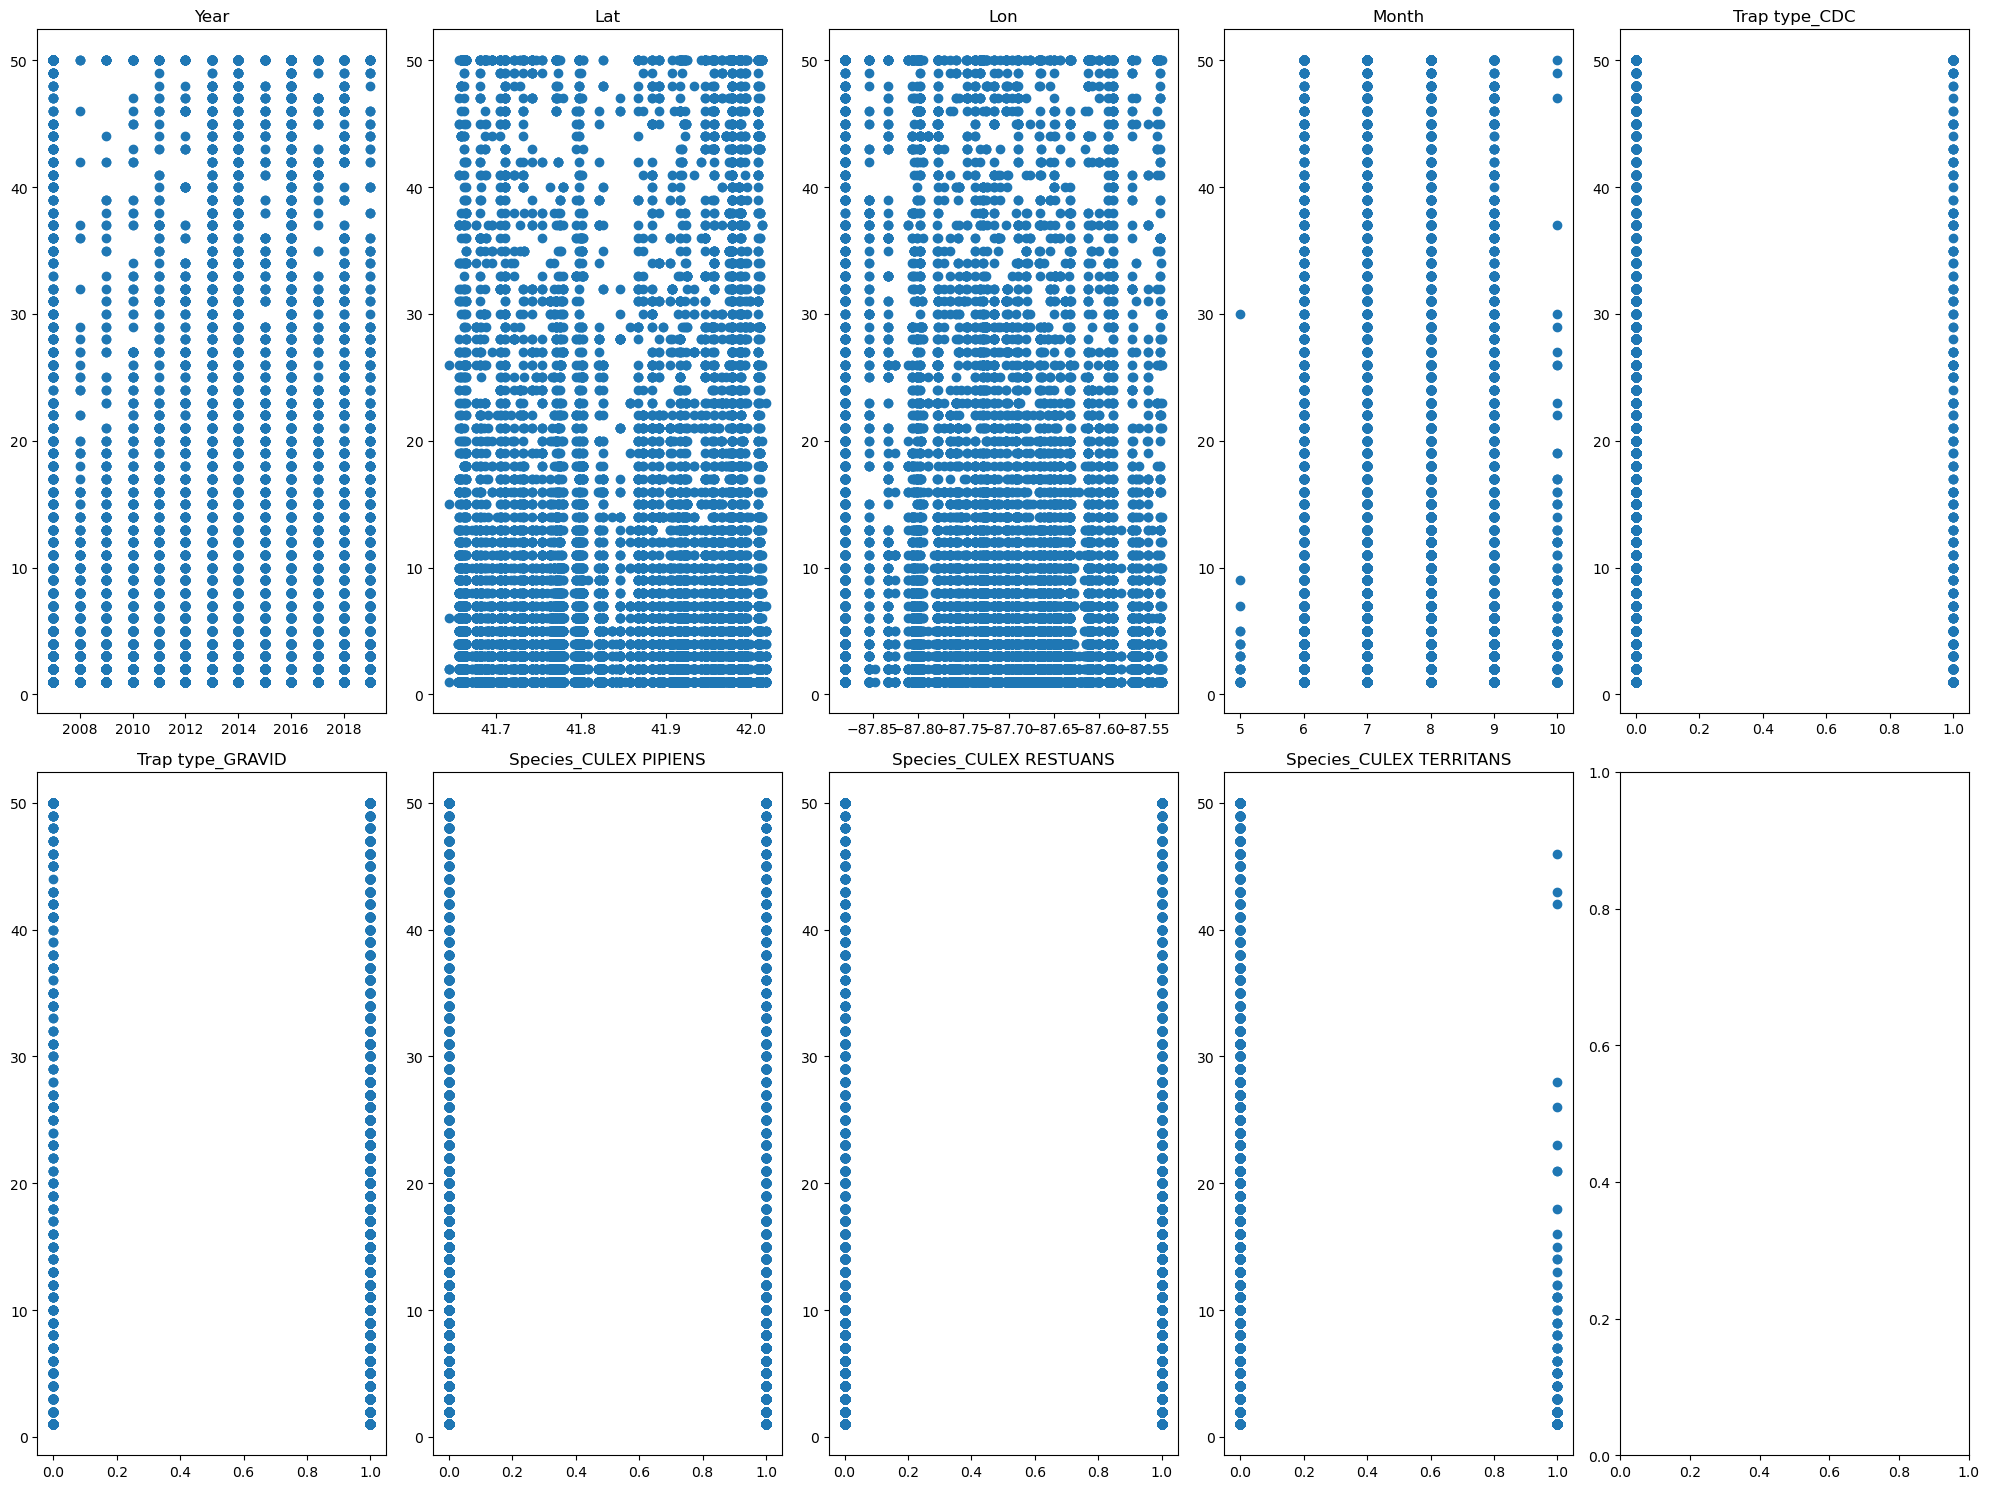

In [41]:
# Loop over the columns and plot the relationship between each column and the target
plt.subplots(2, 5, figsize=(20, 15))

count = 1

for col in X2.columns:
    plt.subplot(2, 5, count)
    plt.scatter(X2[col], y2)
    plt.title(col)
    
    count += 1
    
plt.tight_layout()
plt.show()

We don't have a linear relationship between any of the independent variable and the target variable. It may be because there is very less colinearity.

To evaluate this further, we can look at the correlation between Mosquito number and the independent columns:

In [42]:
#to check if there is any statistically significant correlation between 
#independent variables and the mosquito number

X1.corr()[['Mosquito number']].sort_values(by= ['Mosquito number'], ascending = False)

,Mosquito number
Mosquito number,1.000000
Year,0.129326
Lat,0.096820
Trap type_CDC,0.094147
Species_CULEX RESTUANS,0.070999
Species_CULEX PIPIENS,0.014730
Month,-0.040426
Trap type_GRAVID,-0.138275
Species_CULEX TERRITANS,-0.150962
Lon,-0.151421


The correlation values are very low. Year is positively correlated with mosquito number. Trap type_cdc, Latitude, species culex pipens and species restuans are also positively correlated but correlation coefficient is very less. Longiutude, species Culex territans, month and trap type gravid are negatively correlated.

**Are these correlations statistically significant?**

If we want to check if these correlations are statistically significant or not we can perform pearson's correlation test. 
Assumptions of pearson's correlation test:
1. Level of Measurement: The two variables should be measured at the interval.
2. Linear Relationship: There should exist a linear relationship between the two variables. (no linearity was observed when plotting the graphs)
3. Normality: Both variables should be roughly normally distributed. (we can test if the mosquito number is normally ditributed or not.)

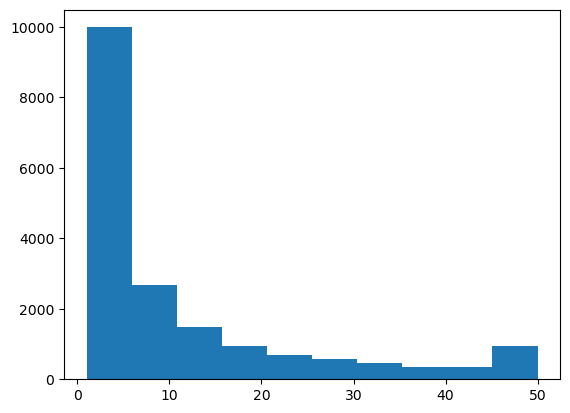

In [43]:
#histogram plot to check normality
plt.figure()
plt.hist(wnv['Mosquito number'])
plt.show()

It is right skewed. We can check if it will be normal when we increase the sample size.

In [44]:
# we can sample it from our data and calculate the means of each sampe and plot a histogram for it

smpl_means = []

for i in range(10000):
    
    smpl = wnv['Mosquito number'].sample(frac=.5)
    
    smpl_means.append(np.mean(smpl))
    

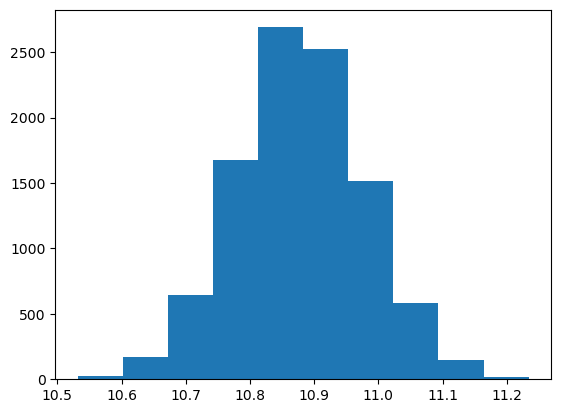

In [45]:
# histogram of sample means

plt.figure()
plt.hist(smpl_means)
plt.show()

The histogram plot os sample means of mosquito number come up to be normal. We can proceed and perform a correlation test.

In [46]:
for column in X2:
    
    rho_p= round(stats.pearsonr(X2[column],y2)[1], 2)
    print(f"Pearsons correlation p value between {column} and Mosquito Number is :{rho_p}" )

Pearsons correlation p value between Year and Mosquito Number is :0.0
Pearsons correlation p value between Lat and Mosquito Number is :0.0
Pearsons correlation p value between Lon and Mosquito Number is :0.0
Pearsons correlation p value between Month and Mosquito Number is :0.0
Pearsons correlation p value between Trap type_CDC and Mosquito Number is :0.0
Pearsons correlation p value between Trap type_GRAVID and Mosquito Number is :0.0
Pearsons correlation p value between Species_CULEX PIPIENS and Mosquito Number is :0.05
Pearsons correlation p value between Species_CULEX RESTUANS and Mosquito Number is :0.0
Pearsons correlation p value between Species_CULEX TERRITANS and Mosquito Number is :0.0


All the p values are less than 0.05 except for the p value for Species_CULEX PIPIENS which is just at the border. So we can reject the null hypothesis that there is no relation between the independent variables and the mosquito number. so we can proceed with using these independent variables in our model.

#### Check for Independence or No Multicollienearity

<AxesSubplot:>

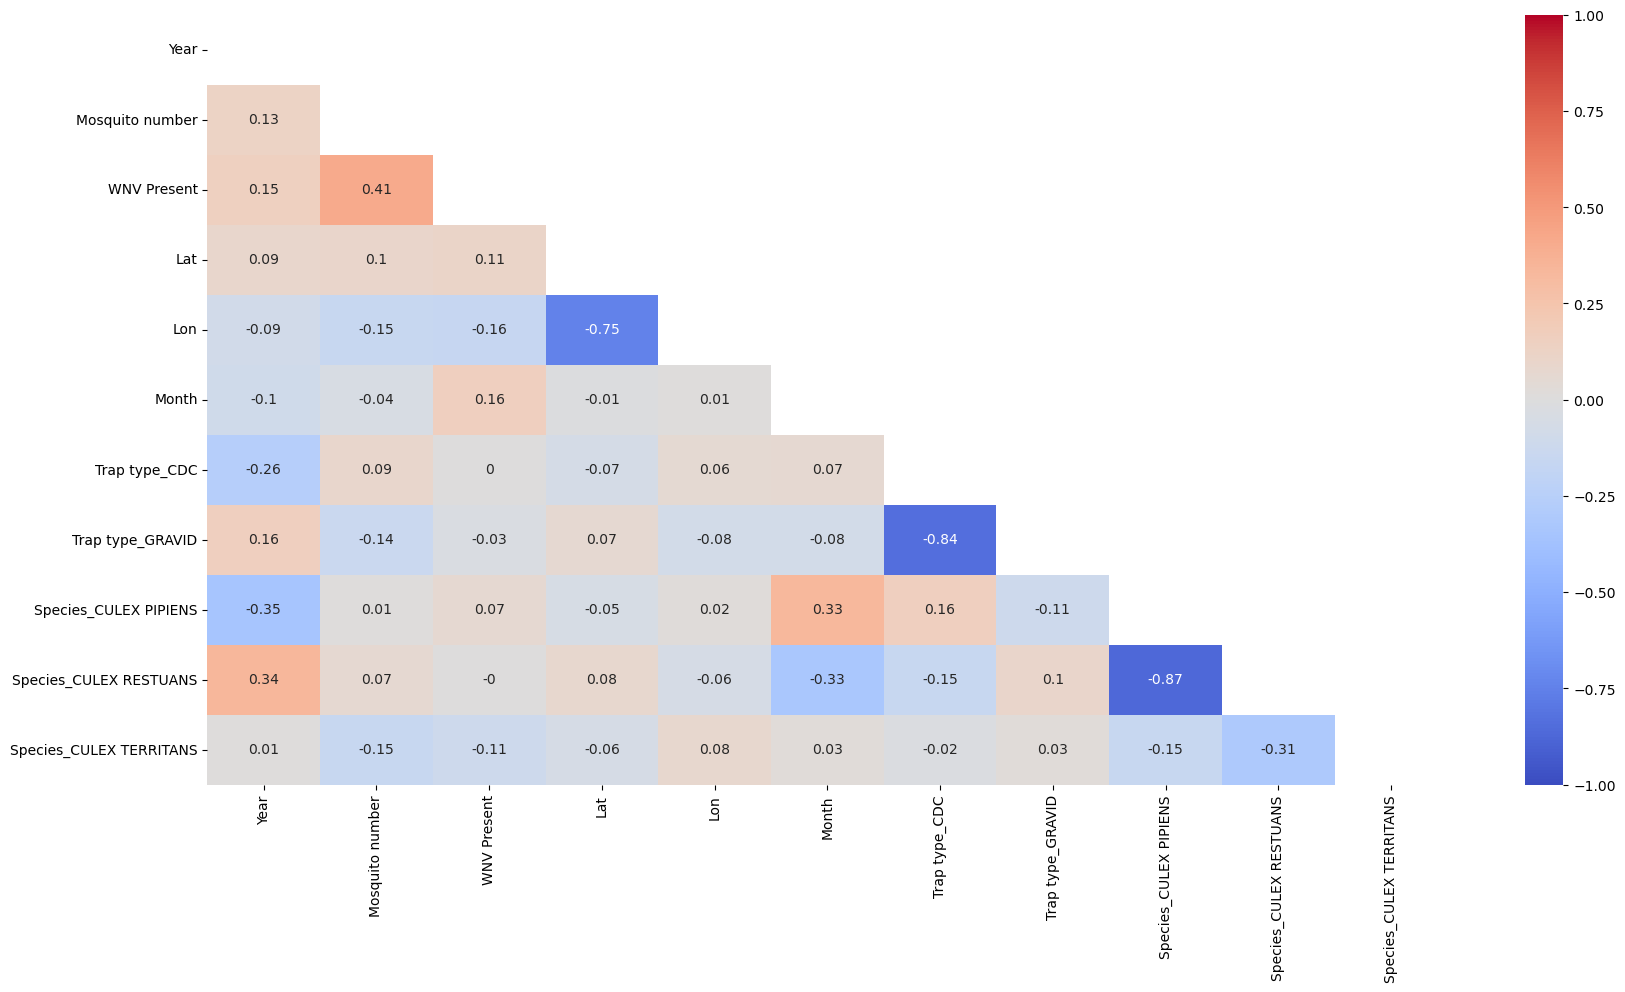

In [47]:
#Plotting heatmap for corrleation between all the variables.

corr_df = dummy_df.corr()

# create a mask for the upper triangle in the corr matrix

mask = np.triu(corr_df)

# visualize with a heatmap

plt.figure(figsize = (20,10))

sns.heatmap(corr_df.round(2),annot = True,vmax = 1,vmin = -1,cmap = 'coolwarm',mask = mask)

Values above 0.5 are usually a concern. As we can see above, there is some strong collinearity in this dataset: for example, Lon is highly correlated with Lat, Trap type CDC is highly correlated with Trap type Gravid, Species Culex Restuans is negatively correlated with species culex pipiens. We need to make sure to keep this in mind when building our model.

### 2.1Modelling-using-backward-selection

We can start with `Backward or Top-Down approach`. We will be calling the first model Linear 1.

#### Linear 1

Before we porceed with running the linear model, we will be creating a helper function as we will be doing liniear regression multiple times.

In [48]:
#Lets create a function for fitting linear regression as we will be calling it multiple times.

def linear_model (X, y):
    
    X_withconstant= sm.add_constant(X)
    
    linear= sm.OLS(y,X_withconstant)
    
    linear_fit= linear.fit()
    
    return linear_fit

In [49]:
#for first model independent variables.
X2.head()

,Year,Lat,Lon,Month,Trap type_CDC,Trap type_GRAVID,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX TERRITANS
0,2019,41.977738,-87.880969,9,0,1,0,1,0
1,2019,41.798211,-87.736925,9,0,1,0,1,0
2,2019,41.987245,-87.689417,9,0,1,0,1,0
3,2019,41.953664,-87.724987,9,0,1,0,1,0
4,2019,41.657069,-87.546049,9,0,1,0,1,0


In [50]:
y2.head(2)

0    2
1    1
Name: Mosquito number, dtype: int64

In [51]:
#calling function to run linear regression.
linear_1=linear_model(X2, y2)

In [52]:
#summary of the model
linear_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     208.9
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        07:36:53   Log-Likelihood:                -73450.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18485   BIC:                         1.470e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -2986.6674    110.679    -26.985      0.000   -3203.609   -2769.726
Year                        0.5272      0.028     18.708      0.000       0.472       0.582
Lat                        -4.8682      1.239     -3.930      0.000      -7.297      -2.440
Lon                       -24.5011      1.503    -16.303      0.000     -27.447     -21.555
Month                      -0.6448      0.101     -6.393      0.000      -0.842      -0.447
Trap type_CDC              -1.8930      1.080     -1.753      0.080      -4.010       0.224
Trap type_GRAVID          -12.9367      0.903    -14.331      0.000     -14.706     -11.167
Species_CULEX PIPIENS       9.7493      0.874     11.157      0.000       8.036      11.462
Species_CULEX RESTUANS      8.5257      0.867      9.830      0.000       6.826      10.226
Species_CULEX TERRITANS     0.4694      0.958      0.490      0.624      -1.407       2.346
==============================================================================
Omnibus:                     4535.449   Durbin-Watson:                   1.551
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8988.201
Skew:                           1.504   Prob(JB):                         0.00
Kurtosis:                       4.618   Cond. No.                     2.36e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The p values for Species_CULEX TERRITANS and Trap type_CDC are >0.05 which means that the coefficients for these variable are not signifiacnt. We will drop these variable and try to model it again.

**Model Assessment with R<sup>2<sup/>** <br>
 
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
| Linear 1 | All                                        | 0.092 |

#### Linear 2

Let us drop the columns Species_CULEX TERRITANS and Trap type_CDC and see how our model performs.

In [53]:
#We will drop Species_CULEX TERRITANS and Trap type_CDC and re run the linear model.
X3=X2.drop(columns= ['Species_CULEX TERRITANS', 'Trap type_CDC'])

In [54]:
#calling function to run linear regression.
linear_2=linear_model(X3, y2)

In [55]:
#summary of the model
linear_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     268.0
Date:                Mon, 12 Dec 2022   Prob (F-statistic):               0.00
Time:                        07:37:32   Log-Likelihood:                -73451.
No. Observations:               18495   AIC:                         1.469e+05
Df Residuals:                   18487   BIC:                         1.470e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -2999.8825    110.380    -27.178      0.000   -3216.237   -2783.528
Year                       0.5388      0.027     19.625      0.000       0.485       0.593
Lat                       -4.7767      1.238     -3.859      0.000      -7.203      -2.350
Lon                      -24.3303      1.500    -16.225      0.000     -27.270     -21.391
Month                     -0.6378      0.101     -6.329      0.000      -0.835      -0.440
Trap type_GRAVID         -11.5949      0.486    -23.859      0.000     -12.547     -10.642
Species_CULEX PIPIENS      9.3675      0.423     22.139      0.000       8.538      10.197
Species_CULEX RESTUANS     8.1644      0.402     20.319      0.000       7.377       8.952
==============================================================================
Omnibus:                     4523.863   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8946.722
Skew:                           1.502   Prob(JB):                         0.00
Kurtosis:                       4.610   Cond. No.                     2.36e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Assessment with R<sup>2<sup/>** <br>
 
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
| Linear 1 | All                                       | 0.092 |
| Linear 2 | All - (Species_CULEX TERRITANS, Trap type_CDC) | 0.092 |

#### Linear 3

We observed that the correlation between latitude and longitude was high and correlation between Species_CULEX Pipens and Culex Restuans was also high so let us see what happens if we remove longitude and Species _Culex Pipiens from the model.

In [56]:
X4=X3.drop(columns= ['Species_CULEX PIPIENS', 'Lon'])

In [57]:
#calling function to run linear regression.
linear_3=linear_model(X4, y2)

In [58]:
#summary of the model
linear_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     207.4
Date:                Mon, 12 Dec 2022   Prob (F-statistic):          5.89e-216
Time:                        07:37:56   Log-Likelihood:                -73841.
No. Observations:               18495   AIC:                         1.477e+05
Df Residuals:                   18489   BIC:                         1.477e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1419.8045     64.143    -22.135      0.000   -1545.531   -1294.078
Year                       0.4908      0.028     17.615      0.000       0.436       0.545
Lat                       10.9119      0.841     12.969      0.000       9.263      12.561
Month                     -0.4220      0.102     -4.121      0.000      -0.623      -0.221
Trap type_GRAVID         -11.6166      0.496    -23.442      0.000     -12.588     -10.645
Species_CULEX RESTUANS     0.6665      0.226      2.951      0.003       0.224       1.109
==============================================================================
Omnibus:                     4653.119   Durbin-Watson:                   1.523
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9308.864
Skew:                           1.542   Prob(JB):                         0.00
Kurtosis:                       4.604   Cond. No.                     1.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Assessment with R<sup>2<sup/>** <br>
 
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
| Linear 1 | All                                       | 0.092 |
| Linear 2 | All - (Species_CULEX TERRITANS, Trap type_CDC) | 0.092 |
| Linear 3 | All - (Species_CULEX TERRITANS, Trap type_CDC, Lon, Species_CULEX PIPIENS) | 0.053 |

The `R squared values` have reduced further. Let us try `Forward or Bottom-Up approach` and re run the model.

### 2.2Modelling-using-forward-selection

#### Linear 4

We will be starting with the highli correlated variable 'Year'.

In [59]:
X5= dummy_df['Year']

In [60]:
#calling function to run linear regression.
linear_4=linear_model(X5, y2)

In [61]:
#summary of the model
linear_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     314.6
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           8.39e-70
Time:                        07:38:13   Log-Likelihood:                -74189.
No. Observations:               18495   AIC:                         1.484e+05
Df Residuals:                   18493   BIC:                         1.484e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -930.6059     53.084    -17.531      0.000   -1034.655    -826.557
Year           0.4677      0.026     17.736      0.000       0.416       0.519
==============================================================================
Omnibus:                     5062.043   Durbin-Watson:                   1.516
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10702.761
Skew:                           1.644   Prob(JB):                         0.00
Kurtosis:                       4.754   Cond. No.                     1.09e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Assessment with R<sup>2<sup/>** <br>
 
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
| Linear 1 | All                                       | 0.092 |
| Linear 2 | All - (Species_CULEX TERRITANS, Trap type_CDC) | 0.092 |
| Linear 3 | All - (Species_CULEX TERRITANS, Trap type_CDC, Lon, Species_CULEX PIPIENS) | 0.053 |
| Linear 4 | Year | 0.017 |

#### Linear 5

Let us add Latitude, species Culex Restuans to this model and see the R**2 value.

In [62]:
X6=dummy_df[['Year','Lat', 'Species_CULEX RESTUANS']]

In [63]:
#calling function to run linear regression.
linear_5=linear_model(X6, y2)

In [64]:
#summary of the model
linear_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Mosquito number   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     155.1
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           2.80e-99
Time:                        07:38:28   Log-Likelihood:                -74116.
No. Observations:               18495   AIC:                         1.482e+05
Df Residuals:                   18491   BIC:                         1.483e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -1220.4482     64.530    -18.913      0.000   -1346.933   -1093.963
Year                       0.4069      0.028     14.509      0.000       0.352       0.462
Lat                        9.8377      0.853     11.537      0.000       8.166      11.509
Species_CULEX RESTUANS     0.7262      0.218      3.338      0.001       0.300       1.153
==============================================================================
Omnibus:                     5090.488   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10847.460
Skew:                           1.646   Prob(JB):                         0.00
Kurtosis:                       4.801   Cond. No.                     1.33e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Model Assessment with R<sup>2<sup/>** <br>
 
| Model | Variables                                  | R<sup>2<sup/>    |
|-------|--------------------------------------------|-------|
| Linear 1 | All                                       | 0.092 |
| Linear 2 | All - (Species_CULEX TERRITANS, Trap type_CDC) | 0.092 |
| Linear 3 | All - (Species_CULEX TERRITANS, Trap type_CDC, Lon, Species_CULEX PIPIENS) | 0.053 |
| Linear 4 | Year | 0.017 |
| Linear 5 | Year, Lat, Species_CULEX RESTUANS | 0.025 |

**So far we see that we got the best result for linear 2 despite removing some variable. Although this R squared value is not acceptable but we will proceed ahead to check for our Linear 2 model if it is meeting the Homoscedasticity and residual normality.**

#### Check for Residuals normality

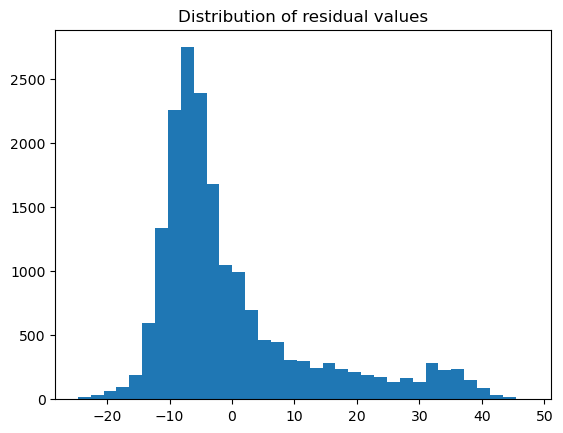

In [65]:
# Plotting the residuals of the model linear 2
plt.figure()
plt.hist(linear_2.resid, bins = 35)
plt.title('Distribution of residual values')
plt.show()

The graph looks normal but it has a small peak towards the right end. We can check if it is not normal by doing a Shapiro-Wilk Test.

In [66]:
# calculating the shapiro test statisic and its p-value

print("Shapiro-Wilk Test: ", stats.shapiro(linear_2.resid))

Shapiro-Wilk Test:  ShapiroResult(statistic=0.8276911377906799, pvalue=0.0)


C:\Users\Soniye\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Although p value is less than 0.05 but we are getting a warning that it may not be accurate. The null hypothesis for the Shapiro-Wilk test is that the data are normally distributed. 
Because the p-value is less than 0.05, then the null hypothesis that the data are normally distributed is rejected.

The Shapiro-Wilk test is very sensitive! Let's try a normal Q-Q plot.

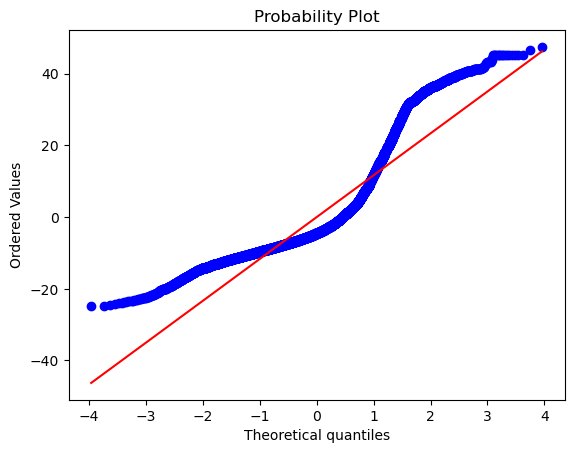

In [67]:
# Normal Q-Q plot

plt.figure()
stats.probplot(linear_2.resid, dist="norm", plot=plt)
plt.show()

The blue line is not hugging the red line so we can say that the residulas are not noramlly distributed.

#### Check for Homoscedasticity

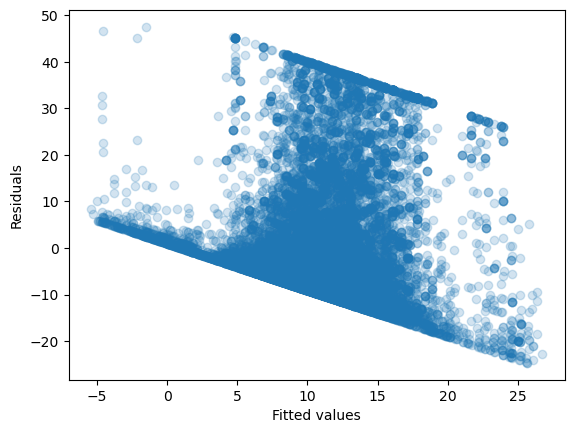

In [68]:
# Plot the residuals and the predicted values
plt.figure()
plt.scatter(linear_2.fittedvalues, linear_2.resid, alpha=0.2)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

Clearly there is a pattern to our graph. It means that variance in your model residuals is not constant of the independent variable(s) change.

So we can conclude that the residuals do not satisfy all our assumptions. Therefore, this model is not fully reliable, meaning that the p-values and coefficients cannot be trusted. 


#### 2.3Conclusion

    1. Our linear model is not reliable.
    2. It is not meeting the linearity assumption. It means there is no linear relationship between our independent variable and dependent variable and therefore we cannot fit linear model.
    3. Even after trying to fit it based on some correlation between independent and dependent variable we are getting a very less R squared value. A good model should have R**2 above 80%. 
    4. Finally we failed to prove residual normality and homoscedasiticity.

### Logistic-Regression

#### Assumptions associated with logistic regression models
There are four assumptions associated with a logistic regression model:

- Binary output: Target variable should be binary.
- Independence/No Multicollinearity: The predictor variables are independent of each other.
- Linearity of independent variables and log odds.
- Large sample size.

We have following independent variables to determine the WNV virus.

In [69]:
#independent variable when determining WNV
X1 = dummy_df.drop(columns= ['WNV Present'], axis = 1)

In [70]:
#target variable
y1=dummy_df['WNV Present']

We already have our target variable as binary. When checking for independence/No Multicollinearilty we can replot the heat map and remind ourselves of the colliner variables.

<AxesSubplot:>

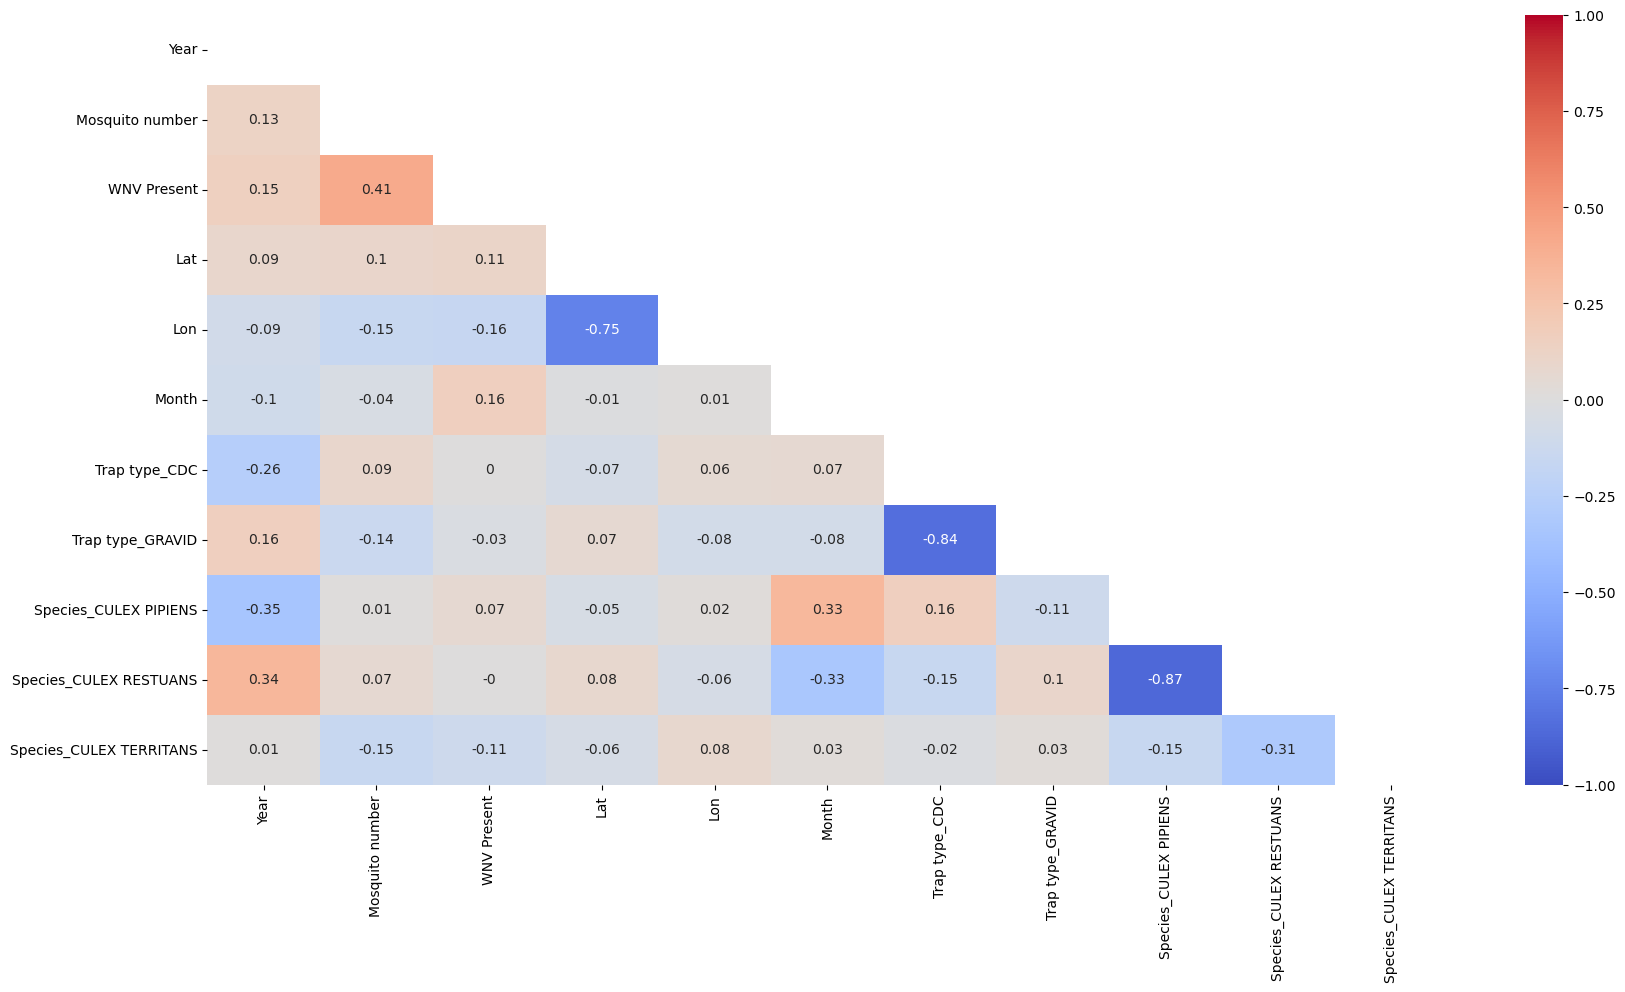

In [71]:
#Plotting heatmap for corrleation between all the variables.

corr_df = dummy_df.corr()

# create a mask for the upper triangle in the corr matrix

mask = np.triu(corr_df)

# visualize with a heatmap

plt.figure(figsize = (20,10))

sns.heatmap(corr_df.round(2),annot = True,vmax = 1,vmin = -1,cmap = 'coolwarm',mask = mask)

Values above 0.5 are usually a concern. As we can see above, there is some strong collinearity in this dataset: for example, Lon is highly correlated with Lat, Trap type CDC is highly correlated with Trap type Gravid, Species Culex Restuans is negatively correlated with species culex pipiens. We need to make sure to keep this in mind when building our model.

Before we porceed with running the logistic model, we will be creating a helper function as we will be doing logistic regression multiple times.

In [72]:
#Lets create a function for fitting logistic regression as we will be calling it multiple times.

def logistic_model(X, y):
    
    X_withconstant= sm.add_constant(X)
    
    logistic= sm.Logit(y, X_withconstant)
    
    logistic_fit= logistic.fit()
    
    return logistic_fit

### 3.1Modelling-using-backward-selection

We can start with `Backward or Top-Down approach`. We will be calling the first model Logit 1.

#### Logit 1

We will start with all the variables and will be using X1 and y1 that we have alreasy instantiated.

In [73]:
logit_1=logistic_model(X1, y1)

Optimization terminated successfully.
         Current function value: 0.406505
         Iterations 8


In [74]:
#summary of our model
logit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18484
Method:                           MLE   Df Model:                           10
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                  0.2209
Time:                        07:44:31   Log-Likelihood:                -7518.3
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -533.6549     25.090    -21.270      0.000    -582.831    -484.479
Year                        0.1214      0.007     18.084      0.000       0.108       0.135
Mosquito number             0.0646      0.001     44.565      0.000       0.062       0.067
Lat                        -0.6445      0.286     -2.253      0.024      -1.205      -0.084
Lon                        -3.5120      0.335    -10.498      0.000      -4.168      -2.856
Month                       0.6247      0.024     25.742      0.000       0.577       0.672
Trap type_CDC               0.1832      0.214      0.858      0.391      -0.235       0.602
Trap type_GRAVID            0.3790      0.171      2.222      0.026       0.045       0.713
Species_CULEX PIPIENS       1.0148      0.323      3.145      0.002       0.382       1.647
Species_CULEX RESTUANS      0.7272      0.322      2.258      0.024       0.096       1.359
Species_CULEX TERRITANS    -1.4929      0.420     -3.556      0.000      -2.316      -0.670
===========================================================================================
"""

The p value for Trap type_CDC is greater than 0.05 that means the coeficient is not significant. We can proceed to drop this variable for our next model and see how our accuracy varies. Before we preoceed let us se the accuracy of our current model.

In [75]:
#checking the probability for predicting WNV positive.
logit_1.predict(sm.add_constant(X1).iloc[0,:])

None    0.464579
dtype: float64

Now we will check what is our model accuracy.

In [76]:
# we want to know what the model accuracy is. We are defining a function for this so that we can call it multiple times.

def accuracy_explorer(model,X,y):
    
    X_const=sm.add_constant(X)
    
    thresholds = np.arange(0,1,.01)
    accuracies = []
    
    for threshold in thresholds:
        
        # how many did we get right
        
        correct_predictions = ((model.predict(X_const) > threshold) ==  y).sum()
        
        # divide by the number of total observations
        
        accuracy = correct_predictions/y.shape[0]
        
        accuracies.append(accuracy)
        
    accuracy_df = pd.DataFrame({'threshold':thresholds,'accuracy':accuracies})    
        
    return accuracy_df

In [77]:
#finding accuracy of our model for different threshold
logit_1_accuracy= accuracy_explorer(logit_1, X1, y1)

In [78]:
(logit_1_accuracy.sort_values('accuracy',ascending = False)).head()

,threshold,accuracy
49,0.49,0.813679
51,0.51,0.813517
50,0.50,0.813247
48,0.48,0.812706
52,0.52,0.812598


In [79]:
#sorting accuracies so that the top row yields the maximum accuracy
(logit_1_accuracy.sort_values('accuracy',ascending = False)).head(1)['accuracy'].values

array([0.81367937])

In [80]:
#function to plot thresholds and accuracy to visually check
def accuracy_plot(full_model_accuracy):
    plt.figure()
    plt.plot(full_model_accuracy['threshold'],full_model_accuracy['accuracy'])
    plt.scatter(full_model_accuracy['threshold'],full_model_accuracy['accuracy'])
    plt.xlabel('Threshold')
    plt.ylabel('Accuracies')
    plt.title(f"Highest accuracy of {full_model_accuracy.sort_values('accuracy',ascending = False).head(1)['accuracy'].values} at threshold of {full_model_accuracy.sort_values('accuracy', ascending = False).head(1)['threshold'].values}")
    plt.show()

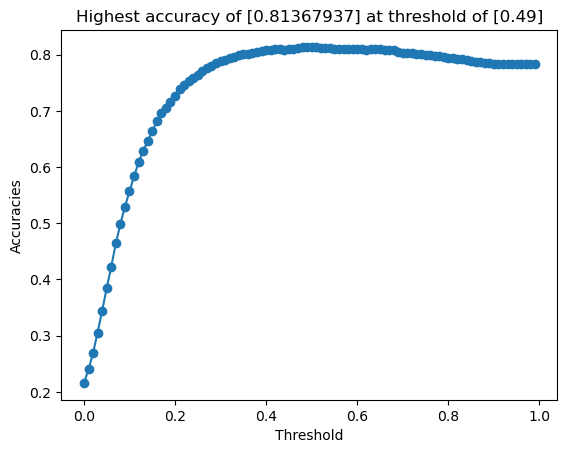

In [81]:
#plotting the threshod values and corresponding accuracies
accuracy_plot(logit_1_accuracy)

In [82]:
#baseline
# with any modeling, without knowning anything about relation between x and y
# we can say with 22% accuracy that people will get WNV positive by a mosquito bite.

wnv['WNV Present'].value_counts(normalize = True)*100

0    78.404974
1    21.595026
Name: WNV Present, dtype: float64

**By just looking at the WNV data we can say with 22 % accuracy that the case is WNV positive**

**Model Assessment with Accuracy** <br>
 
| Model | Variables                        | Threshold   | Accuracy   |
|-------|----------------------------------|-------------|------------|
| Logit 1 | All                            | 0.49  | 81.36 %   |          


We have incresed our accuracy by 59%.

We found that the p value for Trap type_CDC is greater than 0.05 that means the coeficient is not significant. We will proceed to drop this variable for next model.

#### Logit 2

In [83]:
Xlogit2 = dummy_df.drop(columns= ['WNV Present', 'Trap type_CDC'], axis = 1)

In [84]:
#running logistic regression
logit_2=logistic_model(Xlogit2, y1)

Optimization terminated successfully.
         Current function value: 0.406525
         Iterations 8


In [85]:
#summary of our model
logit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18485
Method:                           MLE   Df Model:                            9
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                  0.2208
Time:                        07:48:05   Log-Likelihood:                -7518.7
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    -531.5770     24.969    -21.290      0.000    -580.514    -482.639
Year                        0.1200      0.007     18.449      0.000       0.107       0.133
Mosquito number             0.0647      0.001     44.574      0.000       0.062       0.067
Lat                        -0.6600      0.286     -2.311      0.021      -1.220      -0.100
Lon                        -3.5294      0.334    -10.566      0.000      -4.184      -2.875
Month                       0.6240      0.024     25.729      0.000       0.576       0.672
Trap type_GRAVID            0.2639      0.105      2.522      0.012       0.059       0.469
Species_CULEX PIPIENS       1.0171      0.323      3.148      0.002       0.384       1.650
Species_CULEX RESTUANS      0.7270      0.322      2.255      0.024       0.095       1.359
Species_CULEX TERRITANS    -1.4908      0.420     -3.549      0.000      -2.314      -0.667
===========================================================================================
"""

In [86]:
#finding accuracy of our model for different thresholds
logit_2_accuracy= accuracy_explorer(logit_2, Xlogit2, y1)

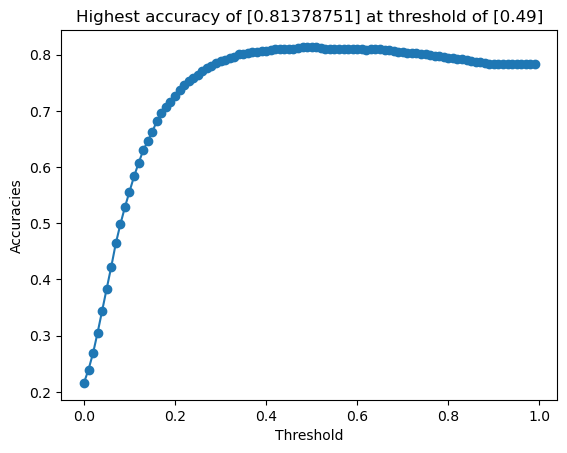

In [87]:
#plotting the threshod values and corresponding accuracies
accuracy_plot(logit_2_accuracy)

**By just looking at the WNV data we can say with 22 % accuracy that the case is WNV positive**

**Model Assessment with Accuracy** <br>
 
| Model | Variables                        | Threshold   | Accuracy   |
|-------|----------------------------------|-------------|------------|
| Logit 1 | All                            | 0.49  | 81.36 %   |          
| Logit 2 | All- Trap type_CDC                            | 0.49  | 81.37 %   | 

### 3.2Modelling-using-forward-selection

Our accuracy for model 2 has improved by 0.01%. We will try `forward selection` method by picking the highly correlated values first.

In [88]:
#quickly checking the correlated values 
dummy_df.corr().loc[:,'WNV Present'].abs().sort_values(ascending = False)

WNV Present                1.000000
Mosquito number            0.408034
Lon                        0.163967
Month                      0.161334
Year                       0.153881
Species_CULEX TERRITANS    0.111394
Lat                        0.110175
Species_CULEX PIPIENS      0.065388
Trap type_GRAVID           0.027359
Trap type_CDC              0.002740
Species_CULEX RESTUANS     0.001498
Name: WNV Present, dtype: float64

We can start by fitting mosquito number first and then we will add more variables and check if our accuracy is improved or not. 

#### Logit 3

In [89]:
#initiating independent variable.
Xlogit3= dummy_df['Mosquito number']

In [90]:
#running logistic regression
logit_3=logistic_model(Xlogit3, y1)

Optimization terminated successfully.
         Current function value: 0.449355
         Iterations 6


In [91]:
#summary of our model
logit_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18493
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                  0.1387
Time:                        07:48:51   Log-Likelihood:                -8310.8
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.1471      0.028    -77.765      0.000      -2.201      -2.093
Mosquito number     0.0637      0.001     48.970      0.000       0.061       0.066
===================================================================================
"""

In [92]:
#finding accuracy of our model for different thresholds
logit_3_accuracy= accuracy_explorer(logit_3, Xlogit3, y1)

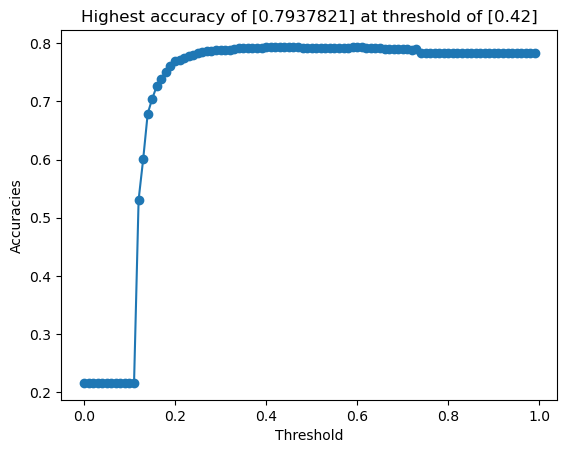

In [93]:
#plotting the threshod values and corresponding accuracies
accuracy_plot(logit_3_accuracy)

**Model Assessment with Accuracy** <br>
 
| Model | Variables                        | Threshold   | Accuracy   |
|-------|----------------------------------|-------------|------------|
| Logit 1 | All                            | 0.49  | 81.36 %   |          
| Logit 2 | All- Trap type_CDC                            | 0.49  | 81.37 %   | 
| Logit 3 | Mosquito Number                            | 0.42  | 79.37 %   | 

We can add next highly correlated variable that is Lon. 

#### Logit 4

In [94]:
#initiating independent variable.
Xlogit4= dummy_df.loc[:,['Mosquito number', 'Lon']]

In [95]:
#running logistic regression
logit_4=logistic_model(Xlogit4, y1)

Optimization terminated successfully.
         Current function value: 0.442757
         Iterations 7


In [96]:
#summary of our model
logit_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18492
Method:                           MLE   Df Model:                            2
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                  0.1514
Time:                        07:49:13   Log-Likelihood:                -8188.8
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -279.6619     17.824    -15.690      0.000    -314.597    -244.727
Mosquito number     0.0617      0.001     47.015      0.000       0.059       0.064
Lon                -3.1638      0.203    -15.572      0.000      -3.562      -2.766
===================================================================================
"""

In [97]:
#finding accuracy of our model for different thresholds
logit_4_accuracy= accuracy_explorer(logit_4, Xlogit4, y1)

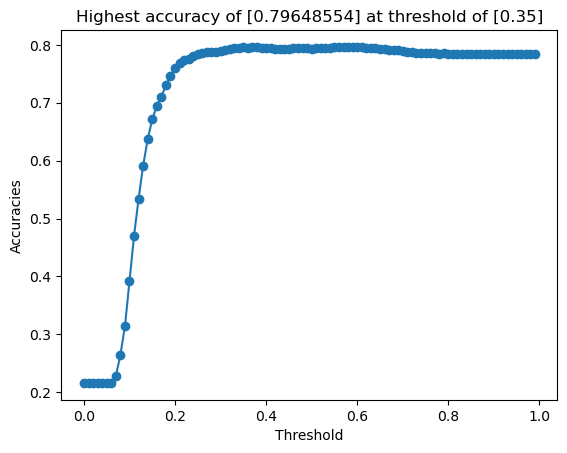

In [98]:
#plotting the threshod values and corresponding accuracies
accuracy_plot(logit_4_accuracy)

**Model Assessment with Accuracy** <br>
 
| Model | Variables                        | Threshold   | Accuracy   |
|-------|----------------------------------|-------------|------------|
| Logit 1 | All                            | 0.49  | 81.36 %   |          
| Logit 2 | All- Trap type_CDC                            | 0.49  | 81.37 %   | 
| Logit 3 | Mosquito Number                            | 0.42  | 79.37 %   | 
| Logit 4 | Mosquito Number, Lon                            | 0.35  | 79.64 %   |

Let us add other parameters i.e Month, Year and Latitude.

#### Logit 5

In [99]:
#initiating independent variable.
Xlogit5= dummy_df.loc[:,['Mosquito number', 'Lon', 'Month', 'Year', 'Lat']]

In [100]:
#running logistic regression
logit_5=logistic_model(Xlogit5, y1)

Optimization terminated successfully.
         Current function value: 0.412050
         Iterations 8


In [101]:
#summary of our model
logit_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18489
Method:                           MLE   Df Model:                            5
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                  0.2102
Time:                        07:49:32   Log-Likelihood:                -7620.9
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -518.9064     23.845    -21.762      0.000    -565.641    -472.172
Mosquito number     0.0666      0.001     47.452      0.000       0.064       0.069
Lon                -3.7199      0.331    -11.250      0.000      -4.368      -3.072
Month               0.6540      0.023     28.563      0.000       0.609       0.699
Year                0.1071      0.006     18.411      0.000       0.096       0.119
Lat                -0.7252      0.284     -2.556      0.011      -1.281      -0.169
===================================================================================
"""

In [102]:
#finding accuracy of our model for different thresholds
logit_5_accuracy= accuracy_explorer(logit_5, Xlogit5, y1)

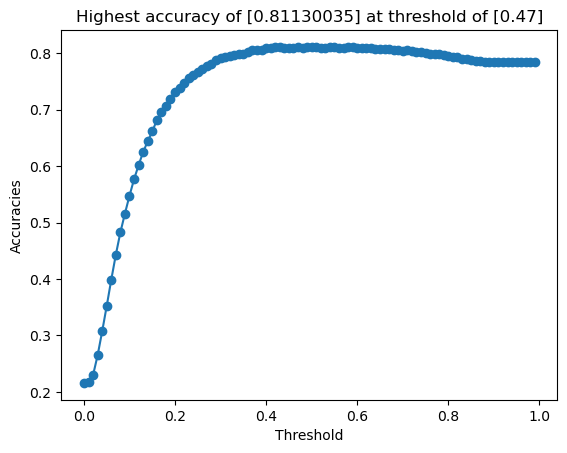

In [103]:
#plotting the threshod values and corresponding accuracies
accuracy_plot(logit_5_accuracy)

**Model Assessment with Accuracy** <br>
 
| Model | Variables                        | Threshold   | Accuracy   |
|-------|----------------------------------|-------------|------------|
| Logit 1 | All                            | 0.49  | 81.36 %   |          
| Logit 2 | All- Trap type_CDC                            | 0.49  | 81.37 %   | 
| Logit 3 | Mosquito Number                            | 0.42  | 79.37 %   | 
| Logit 4 | Mosquito Number, Lon                            | 0.35  | 79.64 %   |
| Logit 5 | Mosquito Number, Lon, Month, Year, Lat                            | 0.47  | 81.13 %   |

We can finally add one more variable Species_CULEX RESTUANS just becuse we had high percentage of these mosquitoes causing WNV virus.

#### Logit 6

In [104]:
#initiating independent variable.
Xlogit6= dummy_df.loc[:,['Mosquito number', 'Lon', 'Month', 'Year', 'Lat', 'Species_CULEX RESTUANS']]

In [105]:
#running logistic regression
logit_6=logistic_model(Xlogit6, y1)

Optimization terminated successfully.
         Current function value: 0.411931
         Iterations 8


In [106]:
#summary of our model
logit_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                18495
Model:                          Logit   Df Residuals:                    18488
Method:                           MLE   Df Model:                            6
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                  0.2105
Time:                        07:50:04   Log-Likelihood:                -7618.7
converged:                       True   LL-Null:                       -9649.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -529.0654     24.351    -21.727      0.000    -576.792    -481.339
Mosquito number            0.0666      0.001     47.470      0.000       0.064       0.069
Lon                       -3.7131      0.331    -11.227      0.000      -4.361      -3.065
Month                      0.6395      0.024     26.745      0.000       0.593       0.686
Year                       0.1121      0.006     17.806      0.000       0.100       0.124
Lat                       -0.7035      0.284     -2.477      0.013      -1.260      -0.147
Species_CULEX RESTUANS    -0.1023      0.049     -2.095      0.036      -0.198      -0.007
==========================================================================================
"""

In [107]:
#finding accuracy of our model for different thresholds
logit_6_accuracy= accuracy_explorer(logit_6, Xlogit6, y1)

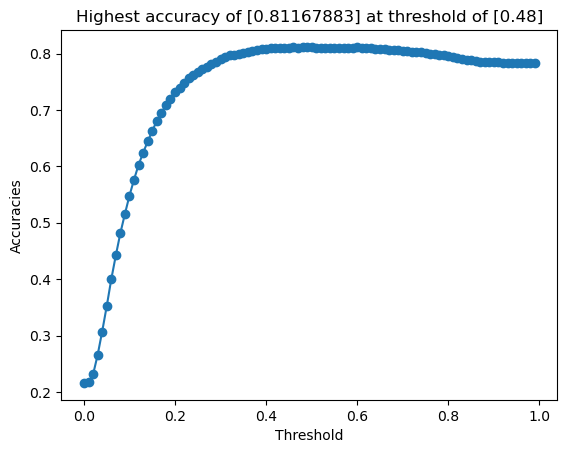

In [108]:
#plotting the threshod values and corresponding accuracies
accuracy_plot(logit_6_accuracy)

**Model Assessment with Accuracy** <br>
 
| Model | Variables                        | Threshold   | Accuracy   |
|-------|----------------------------------|-------------|------------|
| Logit 1 | All                            | 0.49  | 81.36 %   |          
| Logit 2 | All- Trap type_CDC                            | 0.49  | 81.37 %   | 
| Logit 3 | Mosquito Number                            | 0.42  | 79.37 %   | 
| Logit 4 | Mosquito Number, Lon                            | 0.35  | 79.64 %   |
| Logit 5 | Mosquito Number, Lon, Month, Year, Lat                            | 0.47  | 81.13 %   |
| Logit 6 | Mosquito Number, Lon, Month, Year, Lat, Species_CULEX RESTUANS                            | 0.48  | 81.16 %   |

#### 3.3Conclusion

We can say that our model 2 Logit 2 has highest accuracy and is the best fit. 

Suppose, we want to predict if WNV will occur or not based on our location and time. We could go for model 5 that is logit 5 where we can put our parameter and check if WNV is positive or not. Our linear regression should have helped us in getting the mosquito number, unfortunately it is not fitting our assumptions and parameters.

If I am accepting Logit 5, we can get the acceptable coefficients as below:

In [109]:
accepted_model_betas = logit_5.params

In [110]:
#let us calculate the odds of getting WNV wirus if the mosquitoes trapped increase by 5.
Mosquito_number_change = np.exp(accepted_model_betas[1]*5)
print(f"For a increase in mosquito density by 5 numbers the odds of getting WNV virus increses by {round(Mosquito_number_change,2)} ")

For a increase in mosquito density by 5 numbers the odds of getting WNV virus increses by 1.4 


In [113]:
#let us calculate the odds of getting WNV wirus if we change the longitude location by 0.05.
lon_change = np.exp(accepted_model_betas[2]*0.05)
print(f"For a increase in longitude by 0.05 the odds of getting WNV virus increases by {round(lon_change,2)} ")

For a increase in longitude by 0.05 the odds of getting WNV virus increases by 0.83 


Can we predict the probability of getting WNV positive in August 2022 if we visit Chicago airport (41.97 Latitude and -87.90 longitude)? Say the mosquitoes trapped are 5

In [114]:
X_check =[1, 5, -87.90, 8, 2022, 41.97 ]

In [115]:
logit_5.predict(X_check)

array([0.44879979])

There is 44.87 % chances that it will be WNV positive.